In [1]:
from kuramoto.nmf import *

In [2]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 2500
X.shape (2500, 2500)


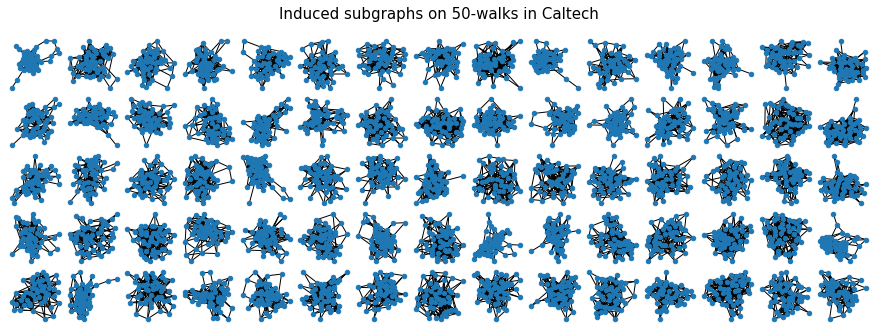

In [3]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [5]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 2.75

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,True
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,True
2496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,False
2497,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
2498,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,True


In [6]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.6252


In [7]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [8]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  0%|                                    | 3/1000 [00:00<00:33, 29.40it/s]

iteration 0, reconstruction error 752104.647284


  2%|▌                                  | 15/1000 [00:00<00:29, 33.20it/s]

iteration 10, reconstruction error 521613.199632


  3%|▉                                  | 27/1000 [00:00<00:28, 33.75it/s]

iteration 20, reconstruction error 519869.654748


  4%|█▏                                 | 35/1000 [00:01<00:28, 34.17it/s]

iteration 30, reconstruction error 513187.647134


  5%|█▋                                 | 47/1000 [00:01<00:27, 34.30it/s]

iteration 40, reconstruction error 495373.248364


  6%|█▉                                 | 55/1000 [00:01<00:27, 34.42it/s]

iteration 50, reconstruction error 481357.495940


  7%|██▎                                | 67/1000 [00:01<00:27, 34.33it/s]

iteration 60, reconstruction error 475924.914014


  8%|██▋                                | 75/1000 [00:02<00:26, 34.54it/s]

iteration 70, reconstruction error 472992.618325


  9%|███                                | 87/1000 [00:02<00:26, 34.61it/s]

iteration 80, reconstruction error 471380.966865


 10%|███▎                               | 95/1000 [00:02<00:26, 34.17it/s]

iteration 90, reconstruction error 470425.661058


 11%|███▋                              | 107/1000 [00:03<00:26, 33.32it/s]

iteration 100, reconstruction error 469799.149634


 12%|███▉                              | 115/1000 [00:03<00:26, 33.68it/s]

iteration 110, reconstruction error 469352.013502


 13%|████▎                             | 127/1000 [00:03<00:24, 34.96it/s]

iteration 120, reconstruction error 469012.666523


 14%|████▌                             | 135/1000 [00:04<00:27, 31.95it/s]

iteration 130, reconstruction error 468741.143200


 15%|████▉                             | 147/1000 [00:04<00:25, 32.97it/s]

iteration 140, reconstruction error 468515.643911


 16%|█████▎                            | 155/1000 [00:04<00:25, 33.06it/s]

iteration 150, reconstruction error 468323.453023


 17%|█████▋                            | 167/1000 [00:04<00:25, 33.18it/s]

iteration 160, reconstruction error 468155.590832


 18%|█████▉                            | 175/1000 [00:05<00:24, 33.67it/s]

iteration 170, reconstruction error 468006.808033


 19%|██████▎                           | 187/1000 [00:05<00:23, 34.32it/s]

iteration 180, reconstruction error 467873.355209


 20%|██████▋                           | 195/1000 [00:05<00:23, 34.31it/s]

iteration 190, reconstruction error 467751.998197


 21%|███████                           | 207/1000 [00:06<00:23, 33.92it/s]

iteration 200, reconstruction error 467640.480141


 22%|███████▎                          | 215/1000 [00:06<00:22, 34.80it/s]

iteration 210, reconstruction error 467537.296202


 23%|███████▋                          | 227/1000 [00:06<00:22, 33.89it/s]

iteration 220, reconstruction error 467441.106768


 24%|███████▉                          | 235/1000 [00:07<00:23, 32.04it/s]

iteration 230, reconstruction error 467350.937390


 25%|████████▍                         | 247/1000 [00:07<00:21, 34.35it/s]

iteration 240, reconstruction error 467265.871199


 25%|████████▌                         | 251/1000 [00:07<00:21, 34.23it/s]

iteration 250, reconstruction error 467185.321048


 26%|█████████                         | 265/1000 [00:08<00:24, 29.77it/s]

iteration 260, reconstruction error 467108.844729


 28%|█████████▍                        | 277/1000 [00:08<00:22, 32.31it/s]

iteration 270, reconstruction error 467036.098716


 28%|█████████▋                        | 285/1000 [00:08<00:22, 31.43it/s]

iteration 280, reconstruction error 466966.636917


 30%|██████████                        | 297/1000 [00:09<00:21, 32.95it/s]

iteration 290, reconstruction error 466900.211222


 30%|██████████▎                       | 305/1000 [00:09<00:20, 33.48it/s]

iteration 300, reconstruction error 466836.582441


 32%|██████████▊                       | 317/1000 [00:09<00:19, 34.33it/s]

iteration 310, reconstruction error 466775.377157


 32%|███████████                       | 324/1000 [00:09<00:25, 26.75it/s]

iteration 320, reconstruction error 466716.441671


 34%|███████████▍                      | 336/1000 [00:10<00:20, 31.86it/s]

iteration 330, reconstruction error 466659.475778


 35%|███████████▊                      | 348/1000 [00:10<00:19, 33.08it/s]

iteration 340, reconstruction error 466604.388183


 36%|████████████                      | 356/1000 [00:10<00:20, 31.46it/s]

iteration 350, reconstruction error 466551.185041


 37%|████████████▍                     | 366/1000 [00:11<00:24, 26.13it/s]

iteration 360, reconstruction error 466499.926605


 38%|████████████▊                     | 375/1000 [00:11<00:29, 21.52it/s]

iteration 370, reconstruction error 466450.511403


 38%|█████████████                     | 384/1000 [00:12<00:26, 23.62it/s]

iteration 380, reconstruction error 466402.908339


 40%|█████████████▍                    | 396/1000 [00:12<00:20, 29.11it/s]

iteration 390, reconstruction error 466357.084449


 41%|█████████████▊                    | 406/1000 [00:13<00:22, 26.37it/s]

iteration 400, reconstruction error 466312.980417


 42%|██████████████▏                   | 418/1000 [00:13<00:18, 31.50it/s]

iteration 410, reconstruction error 466270.493865


 43%|██████████████▍                   | 426/1000 [00:13<00:18, 30.50it/s]

iteration 420, reconstruction error 466229.663321


 44%|██████████████▉                   | 438/1000 [00:14<00:18, 30.96it/s]

iteration 430, reconstruction error 466190.439021


 45%|███████████████▏                  | 446/1000 [00:14<00:18, 30.77it/s]

iteration 440, reconstruction error 466152.744586


 45%|███████████████▍                  | 454/1000 [00:14<00:18, 28.80it/s]

iteration 450, reconstruction error 466116.589188


 46%|███████████████▋                  | 463/1000 [00:14<00:19, 27.62it/s]

iteration 460, reconstruction error 466081.885458


 47%|████████████████                  | 473/1000 [00:15<00:19, 26.87it/s]

iteration 470, reconstruction error 466048.592105


 48%|████████████████▍                 | 483/1000 [00:15<00:20, 25.43it/s]

iteration 480, reconstruction error 466016.636663


 50%|████████████████▉                 | 498/1000 [00:16<00:16, 29.68it/s]

iteration 490, reconstruction error 465985.966728


 51%|█████████████████▏                | 506/1000 [00:16<00:16, 29.93it/s]

iteration 500, reconstruction error 465956.502838


 51%|█████████████████▍                | 514/1000 [00:16<00:16, 29.67it/s]

iteration 510, reconstruction error 465928.175648


 52%|█████████████████▊                | 524/1000 [00:17<00:18, 26.35it/s]

iteration 520, reconstruction error 465900.914735


 54%|██████████████████▏               | 535/1000 [00:17<00:16, 27.94it/s]

iteration 530, reconstruction error 465874.672033


 54%|██████████████████▍               | 544/1000 [00:18<00:21, 21.55it/s]

iteration 540, reconstruction error 465849.433595


 56%|██████████████████▊               | 555/1000 [00:18<00:16, 27.04it/s]

iteration 550, reconstruction error 465825.162779


 56%|███████████████████▏              | 565/1000 [00:18<00:18, 23.75it/s]

iteration 560, reconstruction error 465801.819726


 58%|███████████████████▌              | 576/1000 [00:19<00:14, 28.66it/s]

iteration 570, reconstruction error 465779.364659


 58%|███████████████████▊              | 584/1000 [00:19<00:14, 29.06it/s]

iteration 580, reconstruction error 465757.768320


 60%|████████████████████▎             | 596/1000 [00:19<00:13, 30.69it/s]

iteration 590, reconstruction error 465736.987924


 60%|████████████████████▌             | 604/1000 [00:20<00:12, 30.86it/s]

iteration 600, reconstruction error 465716.973892


 62%|████████████████████▉             | 616/1000 [00:20<00:12, 30.56it/s]

iteration 610, reconstruction error 465697.708096


 62%|█████████████████████▏            | 624/1000 [00:20<00:12, 30.58it/s]

iteration 620, reconstruction error 465679.157772


 64%|█████████████████████▌            | 636/1000 [00:21<00:11, 33.07it/s]

iteration 630, reconstruction error 465661.286554


 65%|██████████████████████            | 648/1000 [00:21<00:10, 34.05it/s]

iteration 640, reconstruction error 465644.027765


 66%|██████████████████████▎           | 656/1000 [00:21<00:11, 30.71it/s]

iteration 650, reconstruction error 465627.348833


 66%|██████████████████████▌           | 664/1000 [00:22<00:10, 31.64it/s]

iteration 660, reconstruction error 465611.233256


 68%|██████████████████████▉           | 676/1000 [00:22<00:09, 32.66it/s]

iteration 670, reconstruction error 465595.661209


 68%|███████████████████████▎          | 684/1000 [00:22<00:09, 33.43it/s]

iteration 680, reconstruction error 465580.602823


 70%|███████████████████████▋          | 695/1000 [00:23<00:10, 28.15it/s]

iteration 690, reconstruction error 465566.022053


 70%|███████████████████████▉          | 703/1000 [00:23<00:09, 31.12it/s]

iteration 700, reconstruction error 465551.909244


 72%|████████████████████████▎         | 715/1000 [00:23<00:10, 27.49it/s]

iteration 710, reconstruction error 465538.256425


 73%|████████████████████████▋         | 727/1000 [00:24<00:08, 31.16it/s]

iteration 720, reconstruction error 465525.029609


 74%|████████████████████████▉         | 735/1000 [00:24<00:08, 32.53it/s]

iteration 730, reconstruction error 465512.193201


 75%|█████████████████████████▍        | 747/1000 [00:24<00:07, 32.49it/s]

iteration 740, reconstruction error 465499.728329


 75%|█████████████████████████▋        | 754/1000 [00:25<00:08, 28.85it/s]

iteration 750, reconstruction error 465487.625047


 77%|██████████████████████████        | 766/1000 [00:25<00:07, 29.27it/s]

iteration 760, reconstruction error 465475.852783


 77%|██████████████████████████▎       | 773/1000 [00:25<00:08, 26.12it/s]

iteration 770, reconstruction error 465464.399942


 78%|██████████████████████████▋       | 785/1000 [00:26<00:07, 27.82it/s]

iteration 780, reconstruction error 465453.257197


 79%|██████████████████████████▉       | 793/1000 [00:26<00:07, 27.90it/s]

iteration 790, reconstruction error 465442.430465


 81%|███████████████████████████▍      | 807/1000 [00:27<00:06, 29.76it/s]

iteration 800, reconstruction error 465431.902370


 82%|███████████████████████████▋      | 815/1000 [00:27<00:05, 32.51it/s]

iteration 810, reconstruction error 465421.649636


 83%|████████████████████████████      | 827/1000 [00:27<00:05, 33.34it/s]

iteration 820, reconstruction error 465411.663694


 84%|████████████████████████████▍     | 835/1000 [00:27<00:04, 33.92it/s]

iteration 830, reconstruction error 465401.925658


 85%|████████████████████████████▊     | 847/1000 [00:28<00:04, 34.41it/s]

iteration 840, reconstruction error 465392.412102


 86%|█████████████████████████████     | 855/1000 [00:28<00:04, 30.71it/s]

iteration 850, reconstruction error 465383.112914


 87%|█████████████████████████████▍    | 867/1000 [00:28<00:04, 30.67it/s]

iteration 860, reconstruction error 465374.012728


 88%|█████████████████████████████▊    | 875/1000 [00:29<00:04, 29.92it/s]

iteration 870, reconstruction error 465365.112955


 89%|██████████████████████████████▏   | 887/1000 [00:29<00:03, 33.06it/s]

iteration 880, reconstruction error 465356.406638


 90%|██████████████████████████████▍   | 895/1000 [00:29<00:03, 26.85it/s]

iteration 890, reconstruction error 465347.878919


 91%|██████████████████████████████▊   | 907/1000 [00:30<00:02, 31.48it/s]

iteration 900, reconstruction error 465339.524832


 92%|███████████████████████████████   | 915/1000 [00:30<00:02, 32.77it/s]

iteration 910, reconstruction error 465331.337016


 92%|███████████████████████████████▍  | 923/1000 [00:30<00:02, 31.59it/s]

iteration 920, reconstruction error 465323.313699


 94%|███████████████████████████████▊  | 935/1000 [00:31<00:02, 30.90it/s]

iteration 930, reconstruction error 465315.447961


 95%|████████████████████████████████▏ | 947/1000 [00:31<00:01, 32.21it/s]

iteration 940, reconstruction error 465307.734865


 96%|████████████████████████████████▍ | 955/1000 [00:31<00:01, 32.63it/s]

iteration 950, reconstruction error 465300.174758


 97%|████████████████████████████████▉ | 967/1000 [00:32<00:00, 33.20it/s]

iteration 960, reconstruction error 465292.751423


 98%|█████████████████████████████████▏| 975/1000 [00:32<00:00, 33.61it/s]

iteration 970, reconstruction error 465285.457446


 99%|█████████████████████████████████▌| 987/1000 [00:32<00:00, 31.69it/s]

iteration 980, reconstruction error 465278.287023


100%|█████████████████████████████████▊| 995/1000 [00:32<00:00, 32.26it/s]

iteration 990, reconstruction error 465271.232531


100%|█████████████████████████████████| 1000/1000 [00:33<00:00, 30.18it/s]




###########################
Shape of W_true: (2500, 16)
###########################




  0%|▏                                   | 5/1000 [00:00<00:21, 46.19it/s]

iteration 0, reconstruction error 429376.543406


  1%|▍                                  | 11/1000 [00:00<00:19, 51.79it/s]

iteration 10, reconstruction error 296801.213516


  2%|▌                                  | 17/1000 [00:00<00:19, 51.29it/s]

iteration 20, reconstruction error 295304.966878


  4%|█▏                                 | 35/1000 [00:00<00:26, 36.42it/s]

iteration 30, reconstruction error 289140.654458


  5%|█▋                                 | 47/1000 [00:01<00:21, 43.75it/s]

iteration 40, reconstruction error 276731.371664
iteration 50, reconstruction error 271316.002225


  6%|██▏                                | 63/1000 [00:01<00:21, 44.13it/s]

iteration 60, reconstruction error 268740.182060


  8%|██▊                                | 80/1000 [00:01<00:19, 46.38it/s]

iteration 70, reconstruction error 267359.121985
iteration 80, reconstruction error 266571.148368


 10%|███▍                               | 97/1000 [00:02<00:21, 41.31it/s]

iteration 90, reconstruction error 266083.085819


 11%|███▋                              | 108/1000 [00:02<00:21, 40.79it/s]

iteration 100, reconstruction error 265753.461680
iteration 110, reconstruction error 265512.873626


 13%|████▍                             | 131/1000 [00:02<00:17, 49.11it/s]

iteration 120, reconstruction error 265326.604446
iteration 130, reconstruction error 265176.702568


 15%|█████                             | 149/1000 [00:03<00:15, 54.14it/s]

iteration 140, reconstruction error 265052.815075
iteration 150, reconstruction error 264948.331159


 17%|█████▋                            | 167/1000 [00:03<00:14, 56.08it/s]

iteration 160, reconstruction error 264858.465106
iteration 170, reconstruction error 264780.235209


 19%|██████▍                           | 191/1000 [00:04<00:14, 53.94it/s]

iteration 180, reconstruction error 264711.207415
iteration 190, reconstruction error 264649.567710


 21%|███████▏                          | 211/1000 [00:04<00:13, 57.24it/s]

iteration 200, reconstruction error 264594.100792
iteration 210, reconstruction error 264543.698024


 22%|███████▌                          | 223/1000 [00:04<00:14, 55.35it/s]

iteration 220, reconstruction error 264497.607649


 24%|████████▏                         | 240/1000 [00:05<00:16, 47.50it/s]

iteration 230, reconstruction error 264455.201377
iteration 240, reconstruction error 264415.991585


 26%|████████▊                         | 258/1000 [00:05<00:13, 53.40it/s]

iteration 250, reconstruction error 264379.410114
iteration 260, reconstruction error 264345.216770


 28%|█████████▍                        | 278/1000 [00:05<00:13, 52.05it/s]

iteration 270, reconstruction error 264313.109064
iteration 280, reconstruction error 264282.835697


 30%|██████████▎                       | 302/1000 [00:06<00:13, 53.51it/s]

iteration 290, reconstruction error 264254.182990
iteration 300, reconstruction error 264227.002755


 31%|██████████▋                       | 314/1000 [00:06<00:12, 53.48it/s]

iteration 310, reconstruction error 264201.103402


 32%|███████████                       | 325/1000 [00:06<00:19, 35.05it/s]

iteration 320, reconstruction error 264176.363495


 34%|███████████▍                      | 335/1000 [00:07<00:16, 39.35it/s]

iteration 330, reconstruction error 264152.796004


 35%|███████████▉                      | 352/1000 [00:07<00:14, 46.09it/s]

iteration 340, reconstruction error 264130.308243
iteration 350, reconstruction error 264108.802171


 37%|████████████▌                     | 369/1000 [00:07<00:13, 45.70it/s]

iteration 360, reconstruction error 264088.164975


 38%|████████████▉                     | 379/1000 [00:08<00:14, 43.85it/s]

iteration 370, reconstruction error 264068.391502


 39%|█████████████▎                    | 390/1000 [00:08<00:12, 48.71it/s]

iteration 380, reconstruction error 264049.460909
iteration 390, reconstruction error 264031.318213


 41%|█████████████▊                    | 407/1000 [00:08<00:14, 41.93it/s]

iteration 400, reconstruction error 264013.936989


 42%|██████████████▎                   | 420/1000 [00:08<00:11, 49.41it/s]

iteration 410, reconstruction error 263997.264054
iteration 420, reconstruction error 263981.233726


 44%|██████████████▉                   | 438/1000 [00:09<00:10, 51.14it/s]

iteration 430, reconstruction error 263965.811947
iteration 440, reconstruction error 263950.945582


 46%|███████████████▌                  | 456/1000 [00:09<00:13, 41.29it/s]

iteration 450, reconstruction error 263936.632690


 47%|███████████████▊                  | 466/1000 [00:09<00:12, 43.59it/s]

iteration 460, reconstruction error 263922.838407
iteration 470, reconstruction error 263909.534517


 49%|████████████████▌                 | 488/1000 [00:10<00:10, 49.09it/s]

iteration 480, reconstruction error 263896.688973
iteration 490, reconstruction error 263884.270059


 51%|█████████████████▎                | 511/1000 [00:10<00:09, 52.92it/s]

iteration 500, reconstruction error 263872.268846
iteration 510, reconstruction error 263860.641309


 53%|█████████████████▉                | 529/1000 [00:11<00:09, 49.82it/s]

iteration 520, reconstruction error 263849.346519


 54%|██████████████████▍               | 541/1000 [00:11<00:09, 48.77it/s]

iteration 530, reconstruction error 263838.353268
iteration 540, reconstruction error 263827.670499


 56%|███████████████████               | 560/1000 [00:11<00:08, 53.10it/s]

iteration 550, reconstruction error 263817.284243
iteration 560, reconstruction error 263807.170452


 58%|███████████████████▋              | 578/1000 [00:12<00:08, 52.42it/s]

iteration 570, reconstruction error 263797.322507
iteration 580, reconstruction error 263787.728845


 60%|████████████████████▍             | 602/1000 [00:12<00:07, 52.93it/s]

iteration 590, reconstruction error 263778.356380
iteration 600, reconstruction error 263769.196196


 62%|█████████████████████             | 620/1000 [00:12<00:07, 52.03it/s]

iteration 610, reconstruction error 263760.217945


 63%|█████████████████████▎            | 626/1000 [00:13<00:07, 51.77it/s]

iteration 620, reconstruction error 263751.414768
iteration 630, reconstruction error 263742.785400


 65%|██████████████████████            | 650/1000 [00:13<00:06, 53.22it/s]

iteration 640, reconstruction error 263734.306389
iteration 650, reconstruction error 263725.973980


 67%|██████████████████████▋           | 668/1000 [00:13<00:06, 53.64it/s]

iteration 660, reconstruction error 263717.769253
iteration 670, reconstruction error 263709.663968


 69%|███████████████████████▌          | 692/1000 [00:14<00:05, 53.04it/s]

iteration 680, reconstruction error 263701.650269
iteration 690, reconstruction error 263693.705127


 71%|████████████████████████▏         | 710/1000 [00:14<00:05, 52.94it/s]

iteration 700, reconstruction error 263685.821830
iteration 710, reconstruction error 263678.002949


 73%|████████████████████████▊         | 728/1000 [00:14<00:05, 52.65it/s]

iteration 720, reconstruction error 263670.251285
iteration 730, reconstruction error 263662.548069


 75%|█████████████████████████▌        | 751/1000 [00:15<00:05, 48.39it/s]

iteration 740, reconstruction error 263654.886862
iteration 750, reconstruction error 263647.264347


 76%|█████████████████████████▉        | 763/1000 [00:15<00:05, 46.39it/s]

iteration 760, reconstruction error 263639.673211


 78%|██████████████████████████▍       | 779/1000 [00:16<00:05, 41.67it/s]

iteration 770, reconstruction error 263632.101984


 78%|██████████████████████████▋       | 784/1000 [00:16<00:04, 43.41it/s]

iteration 780, reconstruction error 263624.532794


 80%|███████████████████████████▏      | 800/1000 [00:16<00:04, 44.91it/s]

iteration 790, reconstruction error 263616.952255
iteration 800, reconstruction error 263609.345150


 82%|███████████████████████████▊      | 817/1000 [00:16<00:03, 49.10it/s]

iteration 810, reconstruction error 263601.702760


 83%|████████████████████████████      | 827/1000 [00:17<00:03, 43.31it/s]

iteration 820, reconstruction error 263594.028599


 84%|████████████████████████████▍     | 838/1000 [00:17<00:03, 48.23it/s]

iteration 830, reconstruction error 263586.327563
iteration 840, reconstruction error 263578.605256


 86%|█████████████████████████████▏    | 860/1000 [00:17<00:03, 46.28it/s]

iteration 850, reconstruction error 263570.854656
iteration 860, reconstruction error 263563.066518


 88%|█████████████████████████████▊    | 878/1000 [00:18<00:02, 50.96it/s]

iteration 870, reconstruction error 263555.245935
iteration 880, reconstruction error 263547.390244


 90%|██████████████████████████████▋   | 902/1000 [00:18<00:01, 53.20it/s]

iteration 890, reconstruction error 263539.507096
iteration 900, reconstruction error 263531.596790


 92%|███████████████████████████████▎  | 921/1000 [00:19<00:01, 53.37it/s]

iteration 910, reconstruction error 263523.661447
iteration 920, reconstruction error 263515.693384


 94%|███████████████████████████████▉  | 939/1000 [00:19<00:01, 50.08it/s]

iteration 930, reconstruction error 263507.719278


 95%|████████████████████████████████▎ | 950/1000 [00:19<00:01, 47.86it/s]

iteration 940, reconstruction error 263499.720529


 96%|████████████████████████████████▋ | 960/1000 [00:19<00:00, 45.91it/s]

iteration 950, reconstruction error 263491.707493


 96%|████████████████████████████████▊ | 965/1000 [00:20<00:00, 43.89it/s]

iteration 960, reconstruction error 263483.679731


 98%|█████████████████████████████████▎| 981/1000 [00:20<00:00, 46.88it/s]

iteration 970, reconstruction error 263475.663060
iteration 980, reconstruction error 263467.638503


100%|█████████████████████████████████| 1000/1000 [00:20<00:00, 48.34it/s]

iteration 990, reconstruction error 263459.614126


###########################
Shape of W_false: (2500, 16)
###########################




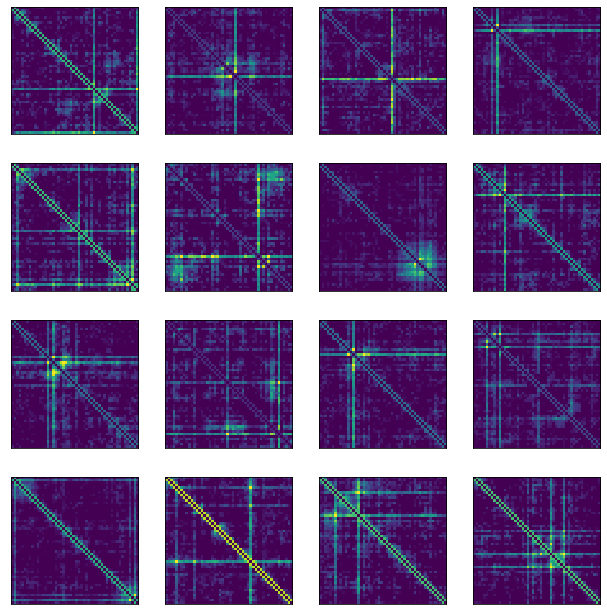

In [9]:
display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_True",
                   figsize = [10,10])

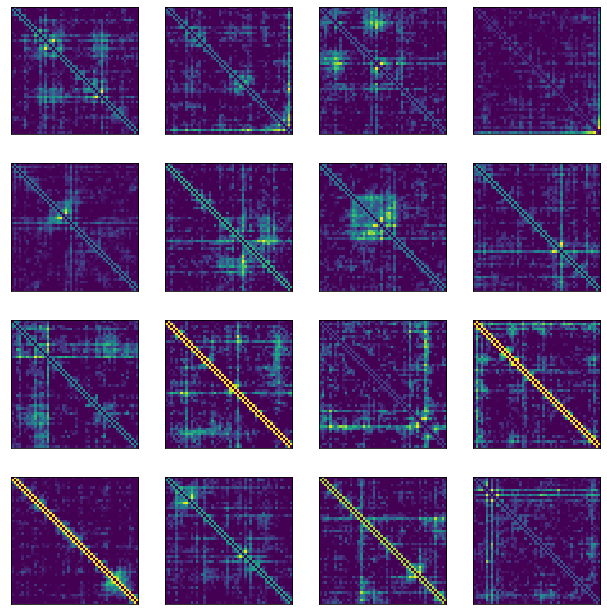

In [10]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_False",
                   figsize = [10,10])

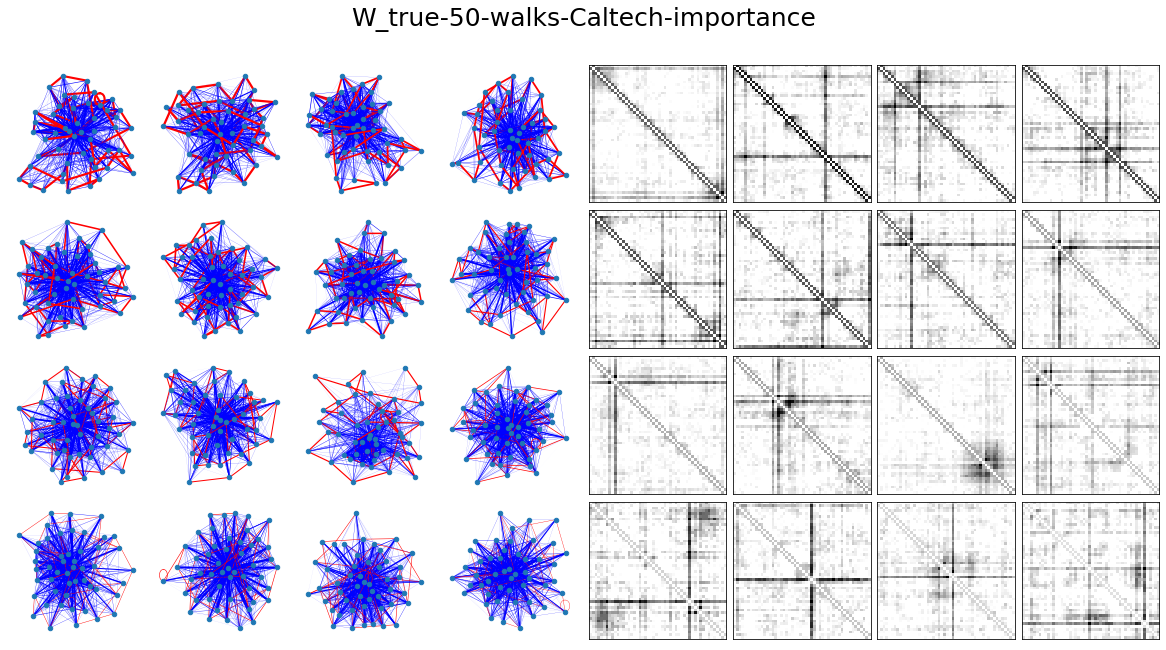

In [11]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

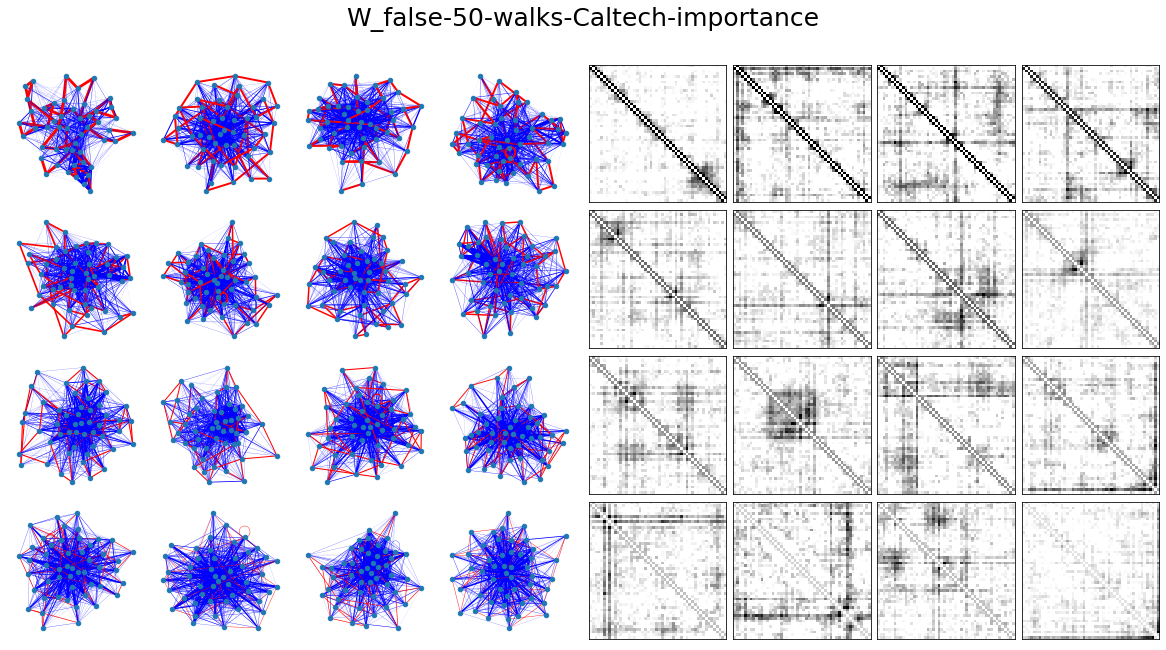

In [12]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)